<a href="https://colab.research.google.com/github/LiSamoht/TinyML-Workshop/blob/main/TinyML_IMU_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit to KAUST's Gesture Recognition Tutorial


In [ ]:
# Setup environment
!pip install pandas numpy matplotlib
!pip install tensorflow

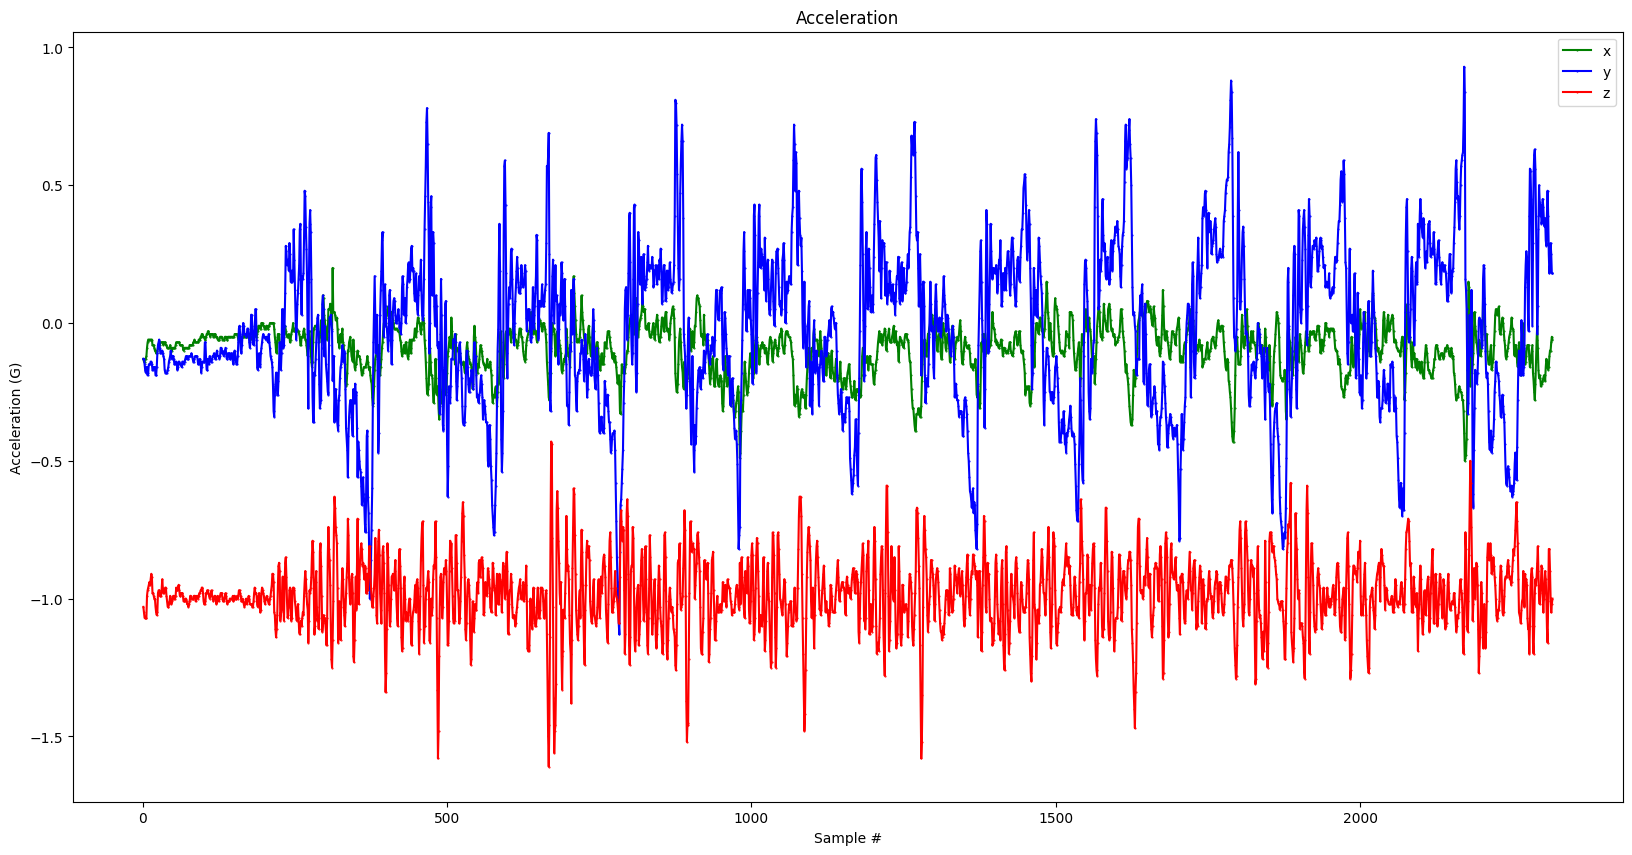

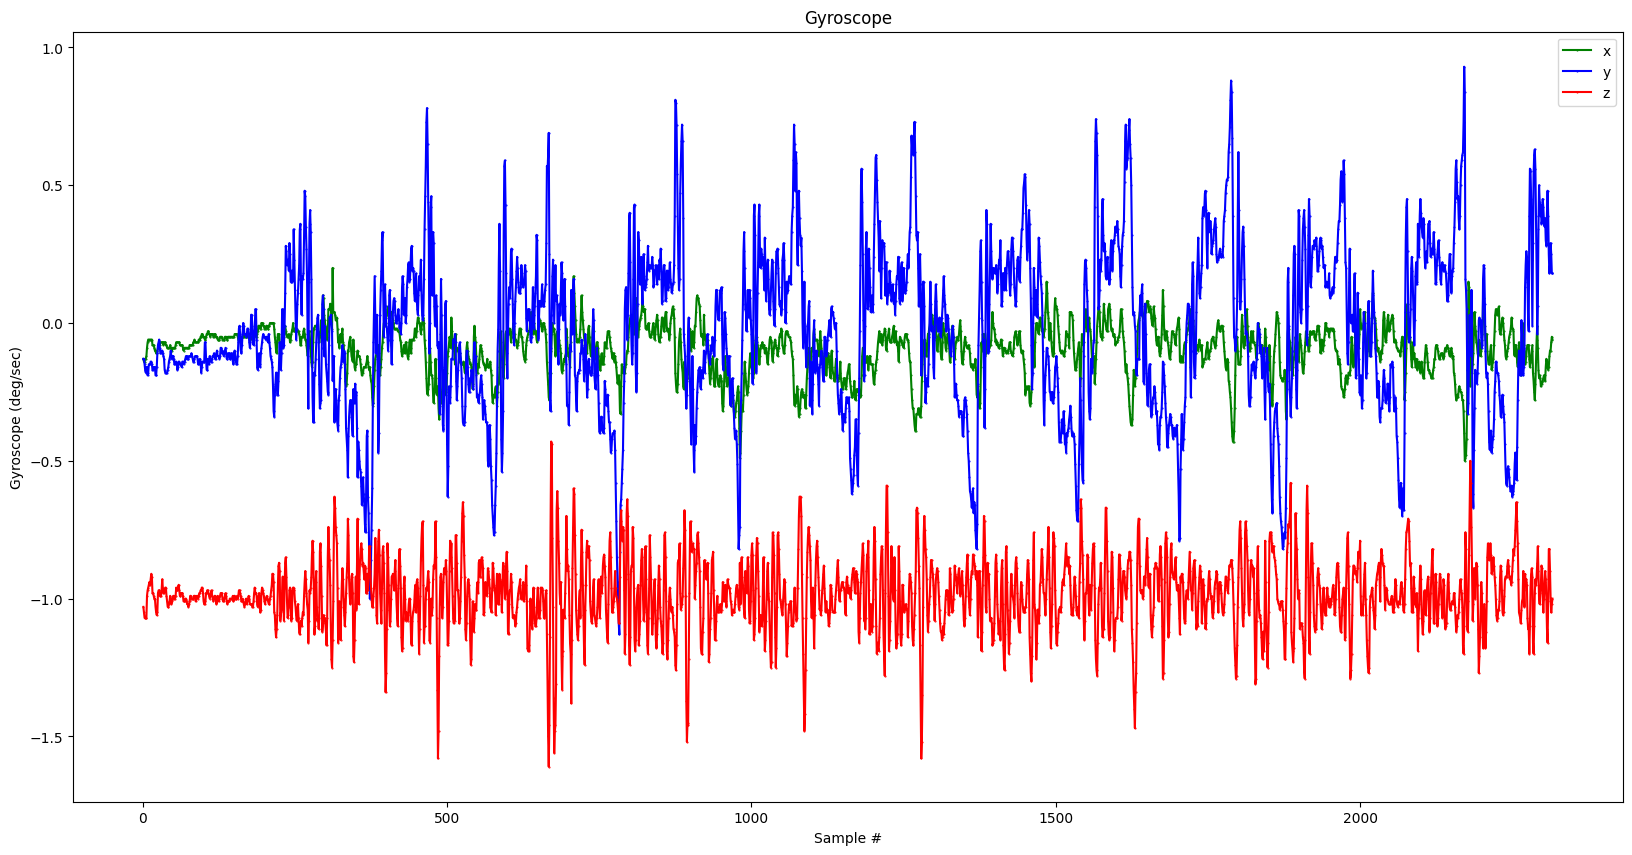

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "leftright2.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g-', label='x', marker='.', markersize=1)
plt.plot(index, df['aY'], 'b-', label='y', marker='.', markersize=1)
plt.plot(index, df['aZ'], 'r-', label='z', marker='.', markersize=1)
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['aX'], 'g-', label='x', marker='.', markersize=1)
plt.plot(index, df['aY'], 'b-', label='y', marker='.', markersize=1)
plt.plot(index, df['aZ'], 'r-', label='z', marker='.', markersize=1)
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "leftright2",
    "updown",
]

SAMPLES_PER_GESTURE = 104

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.19.0

Processing index 0 for gesture 'leftright2'.
	There are 22 recordings of the leftright2 gesture.
Processing index 1 for gesture 'updown'.
	There are 26 recordings of the updown gesture.
Data set parsing and preparation complete.


In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2877 - mae: 0.5020 - val_loss: 0.2293 - val_mae: 0.4654
Epoch 2/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2762 - mae: 0.5228 - val_loss: 0.2497 - val_mae: 0.4997
Epoch 3/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2493 - mae: 0.4992 - val_loss: 0.2445 - val_mae: 0.4942
Epoch 4/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2507 - mae: 0.5005 - val_loss: 0.2460 - val_mae: 0.4959
Epoch 5/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2483 - mae: 0.4979 - val_loss: 0.2428 - val_mae: 0.4921
Epoch 6/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2577 - mae: 0.5074 - val_loss: 0.2384 - val_mae: 0.4860
Epoch 7/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2657 - mae: 0.5151 - val_loss: 0.2464 - val_mae: 0.4963
Epoch 8/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2513 - mae: 0.5012 - val_loss: 0.2520 - val_mae: 0.5019
Epoch 9/600
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.24

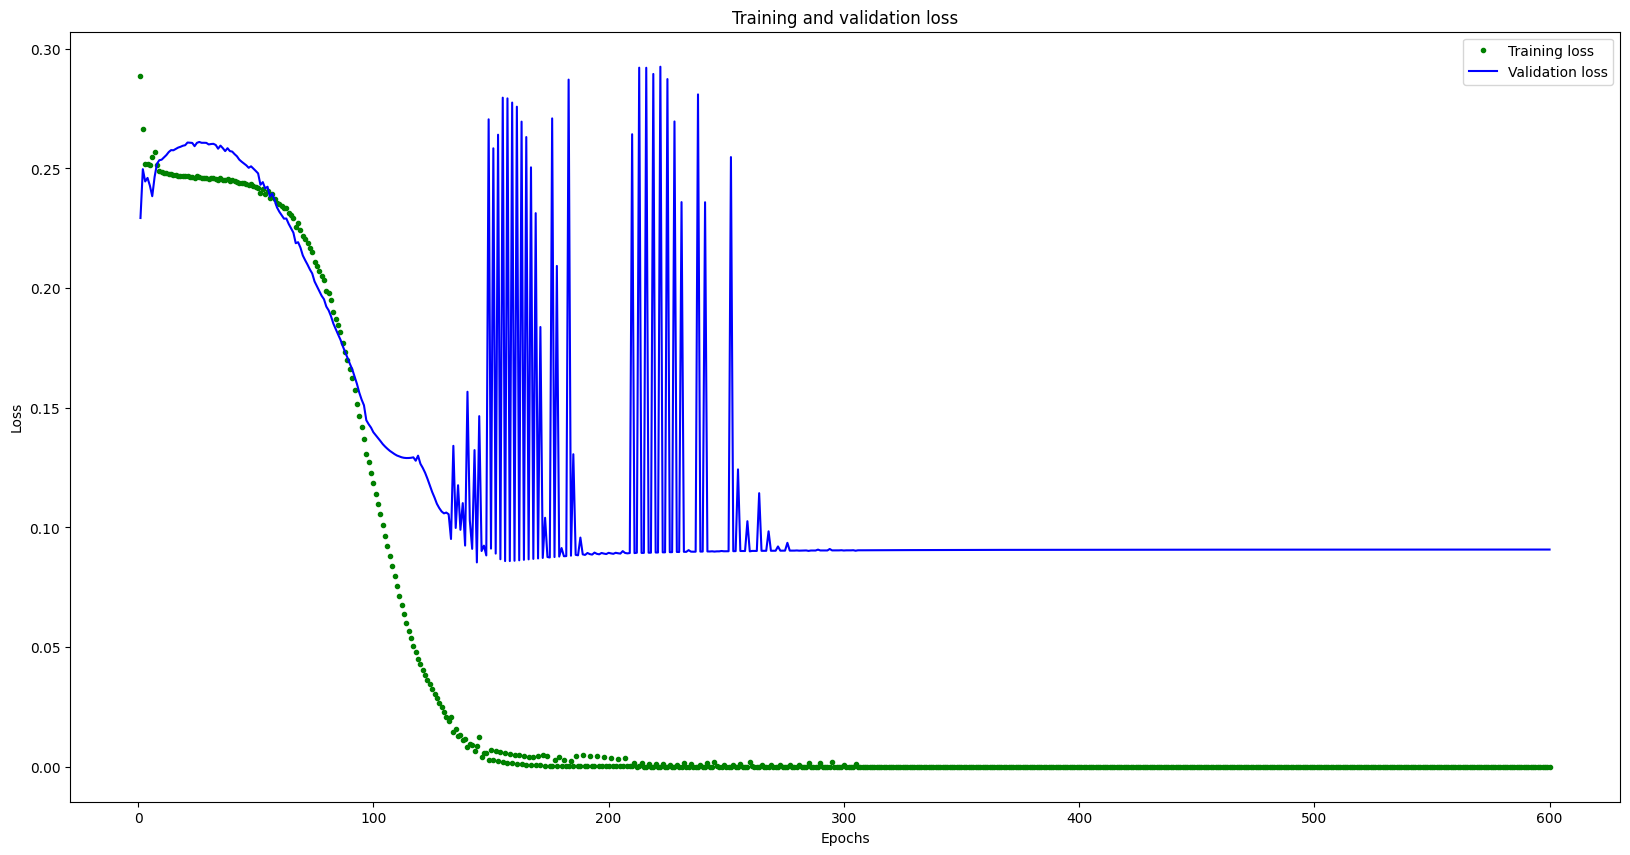

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

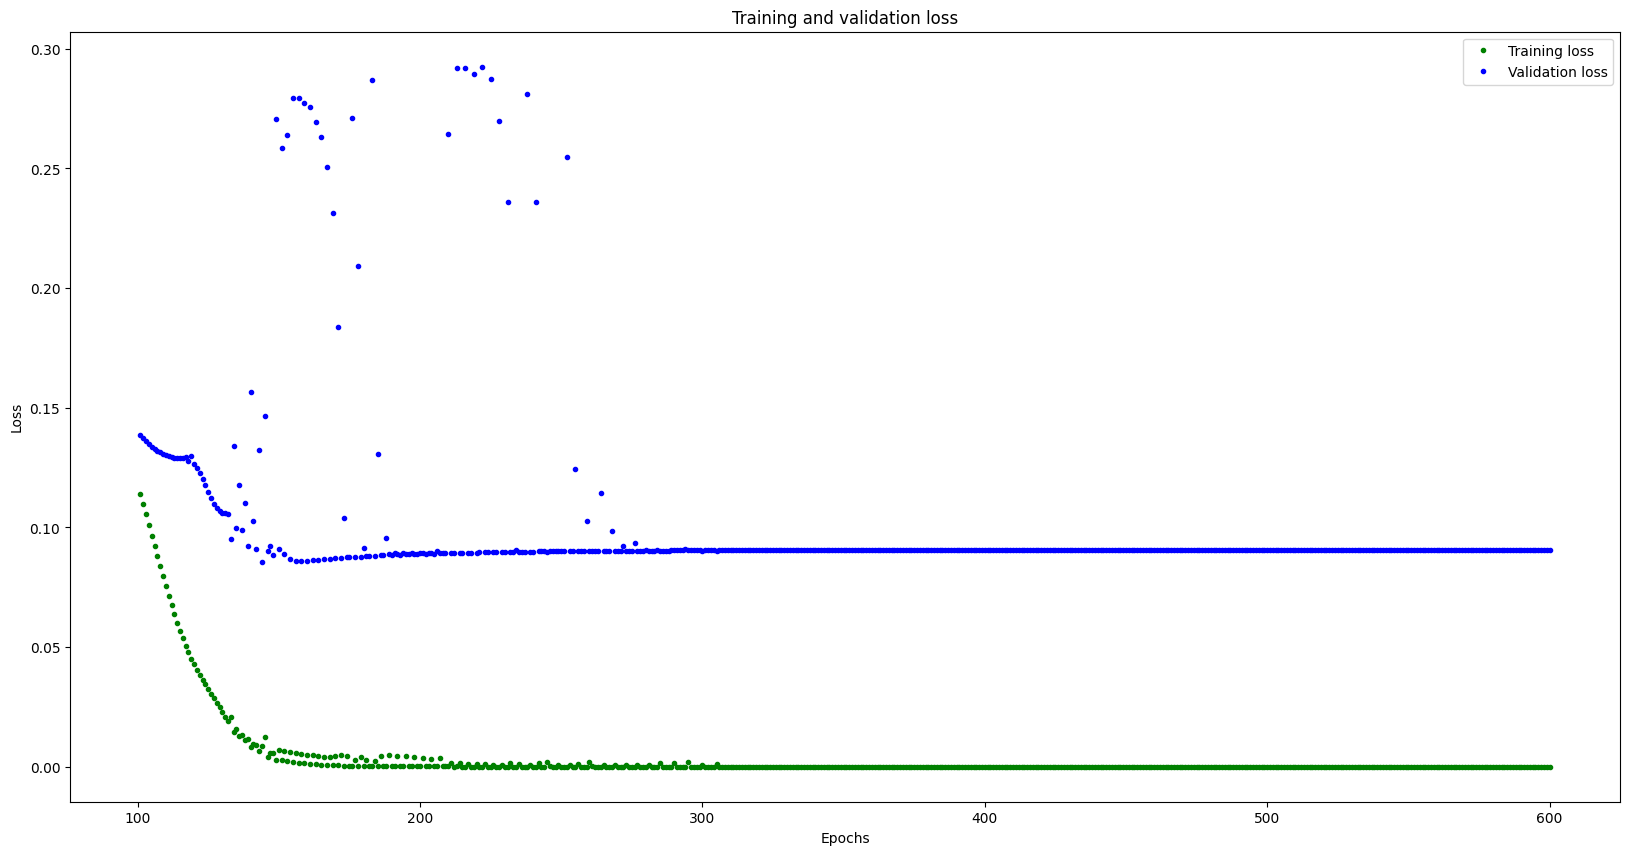

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

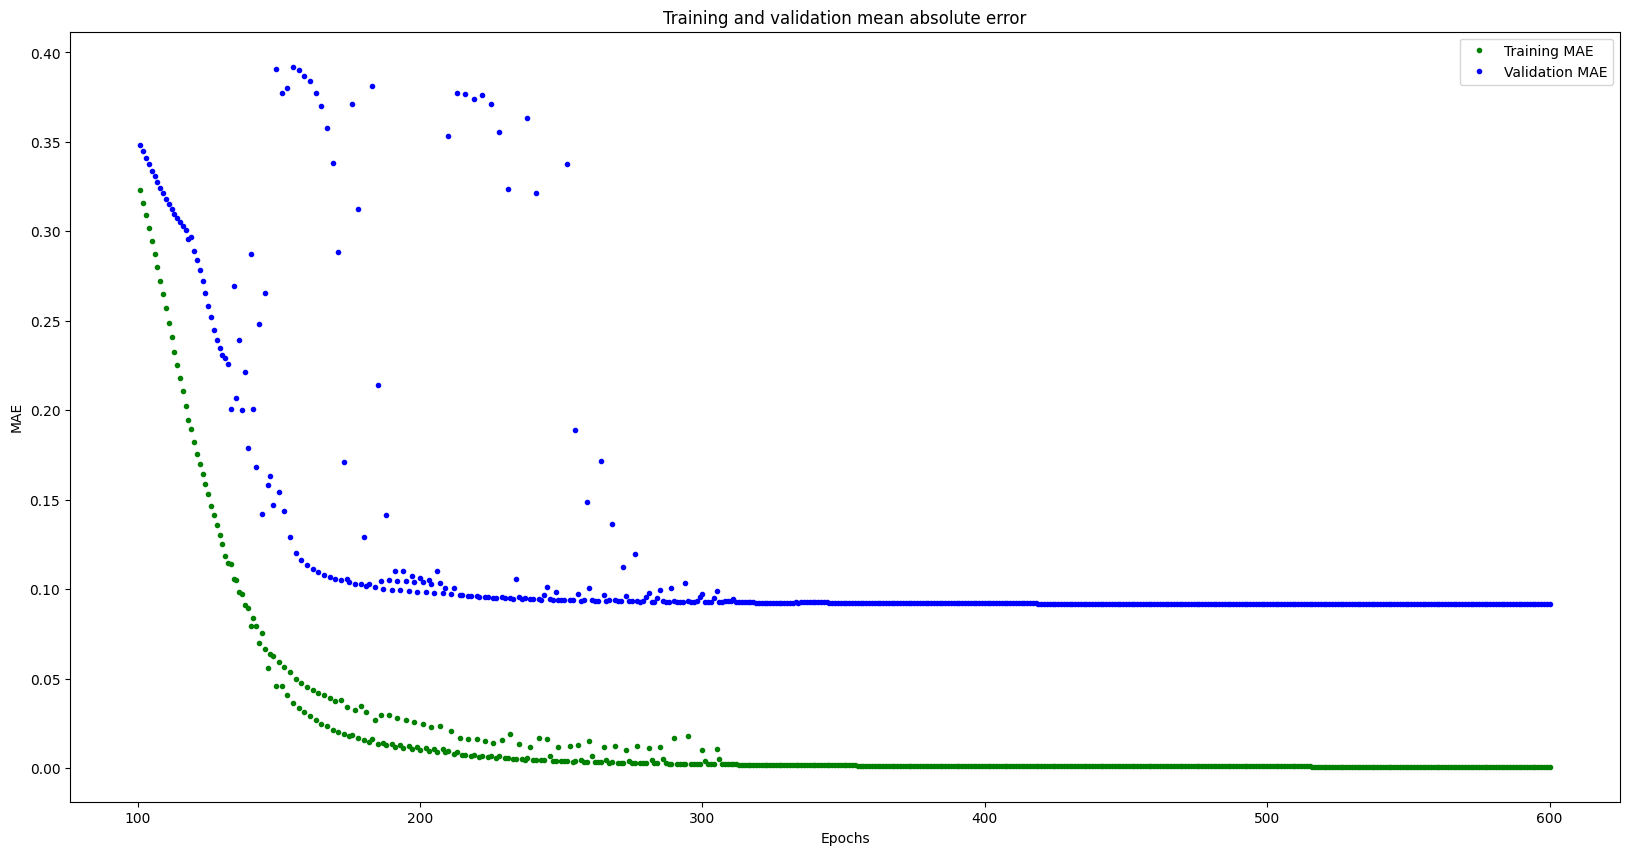

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

TensorFlow version = 2.19.0


leftright2 data shape: (2316, 6)
Acceleration ranges: X[-0.50, 0.20], Y[-1.13, 0.93], Z[-1.61, -0.43]
Gyroscope ranges: X[-265.20, 363.40], Y[-133.79, 93.81], Z[-374.51, 427.43]

updown data shape: (2765, 6)
Acceleration ranges: X[-1.34, 1.00], Y[-0.98, 0.58], Z[-2.55, 0.88]
Gyroscope ranges: X[-124.45, 302.92], Y[-412.11, 335.69], Z[-124.82, 116.21]

Total samples: 200
Input shape: (200, 300)
Output shape: (200, 2)

Training samples: 140
Validation samples: 30
Test samples: 30


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,906 (85.57 KB)

 Trainable params: 21,906 (85.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5388 - loss: 0.6903 - val_accuracy: 0.9333 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8390 - loss: 0.5667 - val_accuracy: 1.0000 - val_loss: 0.5059 - learning_rate: 0.0010
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9139 - loss: 0.4928 - val_accuracy: 1.0000 - val_loss: 0.3995 - learning_rate: 0.0010
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9346 - loss: 0.4167 - val_accuracy: 1.0000 - val_loss: 0.3024 - learning_rate: 0.0010
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9203 - loss: 0.3382 - val_accuracy: 1.0000 - val_loss: 0.2124 - learning_rate: 0.0010
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9446 - loss: 0.2638 - val_accuracy: 1.0000 - val_loss: 0.1384 - learning_rate: 0.0010
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9621 - loss: 0.2237 - val_accuracy: 

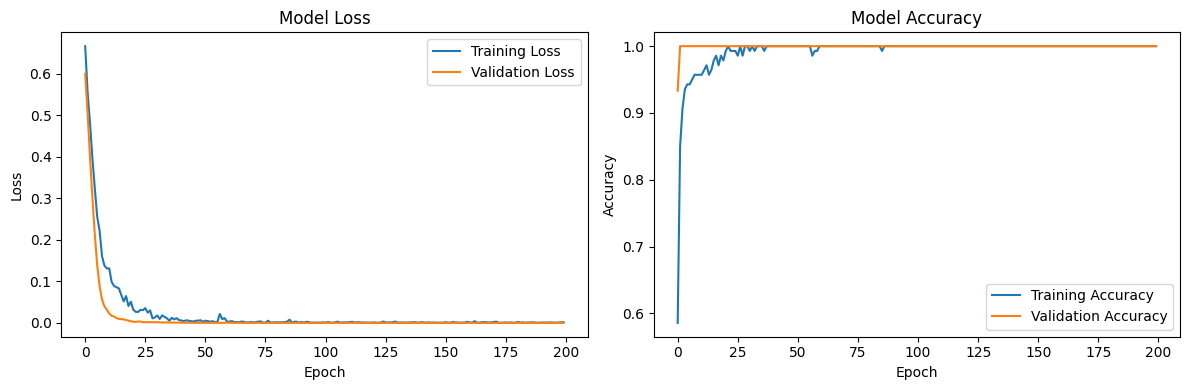

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0037

Test accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# First, let's analyze your data to find appropriate parameters
GESTURES = ["leftright2", "updown"]

# Check the actual data ranges
for gesture in GESTURES:
    df = pd.read_csv(f"/content/{gesture}.csv")
    print(f"\n{gesture} data shape: {df.shape}")
    print(f"Acceleration ranges: X[{df['aX'].min():.2f}, {df['aX'].max():.2f}], "
          f"Y[{df['aY'].min():.2f}, {df['aY'].max():.2f}], "
          f"Z[{df['aZ'].min():.2f}, {df['aZ'].max():.2f}]")
    print(f"Gyroscope ranges: X[{df['gX'].min():.2f}, {df['gX'].max():.2f}], "
          f"Y[{df['gY'].min():.2f}, {df['gY'].max():.2f}], "
          f"Z[{df['gZ'].min():.2f}, {df['gZ'].max():.2f}]")

# Improved data loading with automatic segmentation
def load_gestures(gesture_names, samples_per_gesture=50, overlap=25):
    """
    Load gestures with sliding window approach
    """
    inputs = []
    outputs = []

    for gesture_idx, gesture in enumerate(gesture_names):
        df = pd.read_csv(f"/content/{gesture}.csv")

        # Skip header if present
        if df.iloc[0].astype(str).str.contains('aX|aY|aZ').any():
            df = df.iloc[1:].astype(float)

        # Create sliding windows
        for i in range(0, len(df) - samples_per_gesture, overlap):
            window = df.iloc[i:i + samples_per_gesture]

            # Flatten the window data
            tensor = []
            for _, row in window.iterrows():
                # Better normalization based on typical IMU ranges
                tensor.extend([
                    row['aX'] / 4.0,      # Accelerometer typically ±4g
                    row['aY'] / 4.0,
                    row['aZ'] / 4.0,
                    row['gX'] / 500.0,    # Gyroscope typically ±500 deg/s
                    row['gY'] / 500.0,
                    row['gZ'] / 500.0
                ])

            inputs.append(tensor)
            outputs.append(gesture_idx)

    return np.array(inputs), tf.keras.utils.to_categorical(outputs, len(gesture_names))

# Load data with sliding windows
SAMPLES_PER_GESTURE = 50  # 0.5 seconds at 100Hz
inputs, outputs = load_gestures(GESTURES, SAMPLES_PER_GESTURE)

print(f"\nTotal samples: {len(inputs)}")
print(f"Input shape: {inputs.shape}")
print(f"Output shape: {outputs.shape}")

# Split data
num_samples = len(inputs)
indices = np.random.permutation(num_samples)
train_split = int(0.7 * num_samples)
val_split = int(0.85 * num_samples)

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

X_train, y_train = inputs[train_idx], outputs[train_idx]
X_val, y_val = inputs[val_idx], outputs[val_idx]
X_test, y_test = inputs[test_idx], outputs[test_idx]

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Build improved model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SAMPLES_PER_GESTURE * 6,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(GESTURES), activation='softmax')
])

# Use categorical crossentropy for classification
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Add callbacks for better training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    min_lr=0.00001
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Predictions (probabilities):
Sample 0: [0.00196117 0.9980387 ] -> Class 1 (Actual: 1)
Sample 1: [1.4310959e-07 9.9999982e-01] -> Class 1 (Actual: 1)
Sample 2: [9.9999863e-01 1.3685523e-06] -> Class 0 (Actual: 0)
Sample 3: [1.1226203e-07 9.9999982e-01] -> Class 1 (Actual: 1)
Sample 4: [9.9999970e-01 2.3373505e-07] -> Class 0 (Actual: 0)
Sample 5: [9.9999994e-01 1.5108519e-08] -> Class 0 (Actual: 0)
Sample 6: [3.7306120e-11 9.9999994e-01] -> Class 1 (Actual: 1)
Sample 7: [2.1363945e-10 9.9999994e-01] -> Class 1 (Actual: 1)
Sample 8: [9.9294475e-16 9.9999994e-01] -> Class 1 (Actual: 1)
Sample 9: [9.9999970e-01 1.8831753e-07] -> Class 0 (Actual: 0)

Test Accuracy: 100.00%


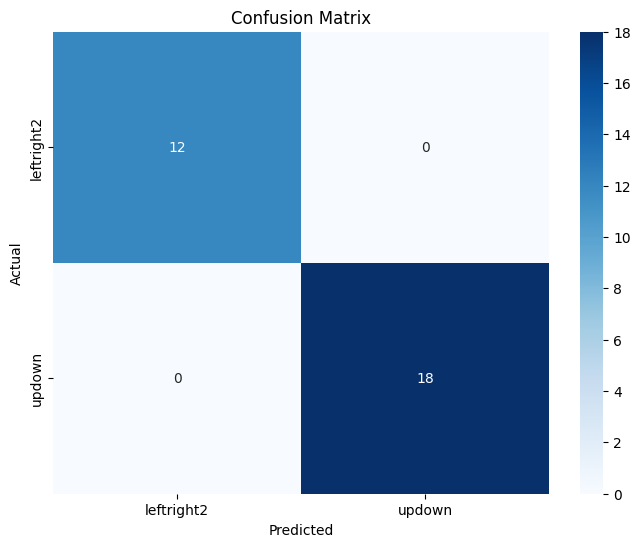

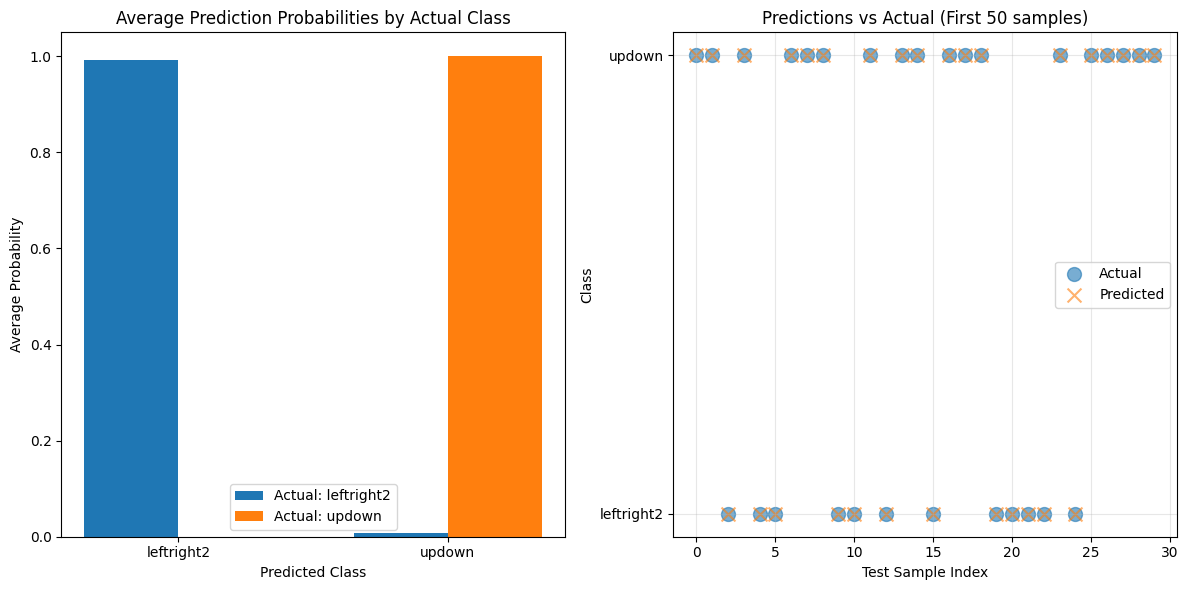

In [ ]:
# Use the model to predict the test inputs
predictions = model.predict(X_test)

# Convert one-hot encoded y_test to class labels (0 or 1)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# Print the predictions and the expected outputs
print("Predictions (probabilities):")
for i in range(min(10, len(predictions))):  # Show first 10
    print(f"Sample {i}: {predictions[i]} -> Class {y_pred_labels[i]} (Actual: {y_test_labels[i]})")

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_test_labels)
print(f"\nTest Accuracy: {accuracy:.2%}")

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GESTURES, yticklabels=GESTURES)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Better visualization: Show prediction confidence
plt.figure(figsize=(12, 6))

# Plot 1: Prediction probabilities
plt.subplot(1, 2, 1)
bar_width = 0.35
x = np.arange(len(GESTURES))

# Average prediction probabilities for each class
for i, gesture in enumerate(GESTURES):
    mask = y_test_labels == i
    if np.any(mask):
        avg_probs = predictions[mask].mean(axis=0)
        plt.bar(x + i*bar_width, avg_probs, bar_width, label=f'Actual: {gesture}')

plt.xlabel('Predicted Class')
plt.ylabel('Average Probability')
plt.title('Average Prediction Probabilities by Actual Class')
plt.xticks(x + bar_width/2, GESTURES)
plt.legend()

# Plot 2: Sample predictions over time
plt.subplot(1, 2, 2)
sample_count = min(50, len(y_test_labels))
plt.scatter(range(sample_count), y_test_labels[:sample_count],
           alpha=0.6, label='Actual', s=100)
plt.scatter(range(sample_count), y_pred_labels[:sample_count],
           alpha=0.6, label='Predicted', marker='x', s=100)
plt.xlabel('Test Sample Index')
plt.ylabel('Class')
plt.title('Predictions vs Actual (First 50 samples)')
plt.yticks(range(len(GESTURES)), GESTURES)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze misclassifications
misclassified = np.where(y_pred_labels != y_test_labels)[0]
if len(misclassified) > 0:
    print(f"\nMisclassified samples: {len(misclassified)} out of {len(y_test_labels)}")
    print("\nFirst few misclassifications:")
    for i in misclassified[:5]:
        print(f"Sample {i}: Predicted {GESTURES[y_pred_labels[i]]}, "
              f"Actual {GESTURES[y_test_labels[i]]}, "
              f"Confidence: {predictions[i].max():.2%}")

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



Saved artifact at '/tmp/tmpztmyiz0l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138377463994640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377463996944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377464000400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138379594984592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377464000016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377463998864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377464000208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138377463992720: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 90108 bytes


In [ ]:
!apt-get -qq install xxd

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 555,700 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
